In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt

df = pd.read_csv(r'Metro_Interstate_Traffic_Volume.csv')
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [2]:
df.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


In [3]:
df.drop_duplicates(subset=['date_time'], keep=False, inplace=True)
df.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,35130.000000,35130.000000,35130.000000,35130.000000,35130.000000
mean,281.458972,0.316409,0.000012,39.525164,3321.773982
std,14.227481,52.455921,0.001266,37.798731,1979.627924
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,271.660000,0.000000,0.000000,1.000000,1315.250000
50%,283.280000,0.000000,0.000000,40.000000,3469.500000
75%,292.770000,0.000000,0.000000,75.000000,4969.000000
max,310.070000,9831.300000,0.210000,100.000000,7280.000000


In [4]:
validate = df['traffic_volume'].tail(10)
df.drop(df['traffic_volume'].tail(10).index,inplace=True)

In [5]:
uni_data = df['traffic_volume']
uni_data.index = df['date_time']
uni_data = uni_data.values

In [6]:
##Test Data
test = uni_data[:48]
print(len(uni_data))
uni_data = uni_data[:-48]
print(len(uni_data))

35120
35072


In [7]:
scaler_x = preprocessing.MinMaxScaler()
x_rescaled = scaler_x.fit_transform(uni_data.reshape(-1, 1))

In [8]:
def custom_ts_univariate_data_prep(dataset, start, end, window, horizon):
  X = []
  y = []

  start = start + window
  if end is None:
    end = len(dataset) - horizon

  for i in range(start, end):
    indicesx = range(i-window, i)
    X.append(np.reshape(dataset[indicesx], (window, 1)))
    indicesy = range(i,i+horizon)
    y.append(dataset[indicesy])

  return np.array(X), np.array(y)

In [9]:
x_train_uni, y_train_uni=custom_ts_univariate_data_prep(x_rescaled, 0, 30000, 48, 10)
x_val_uni, y_val_uni=custom_ts_univariate_data_prep(x_rescaled, 30000, None, 48, 10)

In [10]:
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
##Dataset
trainset = TensorDataset(torch.from_numpy(x_train_uni), torch.from_numpy(y_train_uni))
validset = TensorDataset(torch.from_numpy(x_val_uni), torch.from_numpy(y_val_uni))


trainloader = DataLoader(trainset, batch_size=64, shuffle=True, drop_last=True)
validloader = DataLoader(validset, batch_size=64, shuffle=False)
    

In [11]:
import torch.nn as nn
import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

##Model
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h0 = torch.zeros(self.n_layers, len(x), self.hidden_dim).to(device)
        out, h = self.gru(x,h0.detach())
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    


In [12]:
from tqdm import tqdm
import torch.nn.functional as F
import time, sys

##Train

epochs=100
batch_size=256
#output dimension 1->10
model = GRUNet(input_dim=1, hidden_dim=100, output_dim=10, n_layers=2).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
patience = 10

train_log, val_log = [], []
###TRAIN#####
for epoch in range(1, epochs+1):
    start = time.time()
    total_loss, total_num = 0, 0
    model.train()
    
    for x, y in trainloader:  
        x, y = x.cuda(), y.cuda()
        
        y_hat, h = model(x.float())
        loss = criterion(y_hat, y.float().squeeze(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_num += y.shape[0]
        total_loss += loss.item() * y.shape[0]
    train_loss = total_loss/total_num
    train_log.append(train_loss)

    ######VALID######
    model.eval()
    total_loss, total_num = 0, 0
    
    with torch.no_grad():
        for x, y in validloader:  
            x, y = x.cuda(), y.cuda()
            
            y_hat, h = model(x.float())
            
            loss = criterion(y_hat, y.float().squeeze(-1))
     
            total_num += y.shape[0]
            total_loss += loss.item() * y.shape[0]
        valid_loss = total_loss/total_num
    val_log.append(valid_loss)
    time_stamp = (time.time() - start) / 60
    print('Epoch {} train loss: {:.6f} val loss: {:.6f}  - {:.2f} min'.format(epoch, train_loss, valid_loss, time_stamp))
    if np.argmin(val_log[:epoch + 1]) == epoch - 1:
        torch.save(model.state_dict(), "./gru_horizon.pth") 

#     elif np.argmin(val_log[:epoch + 1]) <= epoch -1 - patience:
#         break

Epoch 1 train loss: 0.050005 val loss: 0.029266  - 0.05 min
Epoch 2 train loss: 0.031902 val loss: 0.027357  - 0.05 min
Epoch 3 train loss: 0.028495 val loss: 0.025696  - 0.05 min
Epoch 4 train loss: 0.026711 val loss: 0.024772  - 0.05 min
Epoch 5 train loss: 0.025438 val loss: 0.023861  - 0.05 min
Epoch 6 train loss: 0.024657 val loss: 0.023051  - 0.05 min
Epoch 7 train loss: 0.023950 val loss: 0.022775  - 0.05 min
Epoch 8 train loss: 0.023492 val loss: 0.023064  - 0.05 min
Epoch 9 train loss: 0.023041 val loss: 0.022774  - 0.05 min
Epoch 10 train loss: 0.022565 val loss: 0.022710  - 0.05 min
Epoch 11 train loss: 0.022173 val loss: 0.022360  - 0.05 min
Epoch 12 train loss: 0.021836 val loss: 0.022883  - 0.05 min
Epoch 13 train loss: 0.021346 val loss: 0.023140  - 0.05 min
Epoch 14 train loss: 0.020952 val loss: 0.023910  - 0.05 min
Epoch 15 train loss: 0.020619 val loss: 0.022752  - 0.05 min
Epoch 16 train loss: 0.020111 val loss: 0.023106  - 0.05 min
Epoch 17 train loss: 0.019677 val

In [15]:
#load model
model = GRUNet(1, 100, 10, 2).to(device)
model.load_state_dict(torch.load('./gru_horizon.pth'))

result = []
# Define Forecast length here
window_len = 10
model.eval()
validatehist = uni_data[:48]
val_rescaled = scaler_x.fit_transform(validatehist.reshape(-1, 1))
val_rescaled = torch.from_numpy(val_rescaled).cuda()
val_rescaled = val_rescaled.reshape((1, 48, 1)) #one_batch

Predicted_results, _ = model(val_rescaled.float())
print(f'predicted : {Predicted_results}')


predicted : tensor([[0.7401, 0.7739, 0.8814, 0.9497, 0.8793, 0.7011, 0.5369, 0.4785, 0.4116,
         0.3323]], device='cuda:0', grad_fn=<AddmmBackward>)


In [19]:
result_inv_trans = scaler_x.inverse_transform(np.array(Predicted_results.detach().cpu().numpy()).reshape(-1,1))

In [20]:
result_inv_trans

array([[5244.156 ],
       [5471.108 ],
       [6193.6094],
       [6652.2515],
       [6179.145 ],
       [4982.486 ],
       [3879.234 ],
       [3486.9805],
       [3037.8767],
       [2504.7275]], dtype=float32)

In [21]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [22]:
timeseries_evaluation_metrics_func(validate, result_inv_trans)

Evaluation metric results:-
MSE is : 2647089.8985351147
MAE is : 1540.6573974609375
RMSE is : 1626.9879835251133
MAPE is : 102.13421364667903
R2 is : -0.7185306059517598



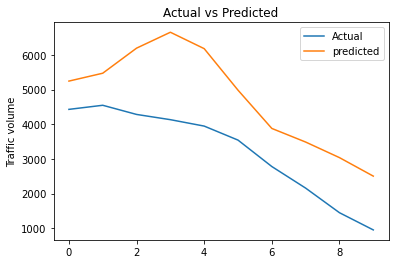

In [23]:
import matplotlib.pyplot as plt
plt.plot(list(validate))
plt.plot(list(result_inv_trans))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()